In [1]:
%cd ..
%cd ..

/home/ltorres/leo/tesis/cloud-classification/code/notebooks
/home/ltorres/leo/tesis/cloud-classification/code


In [2]:
%load_ext autoreload
%autoreload 2

---

In [3]:
from torchvision.io import read_image
import glob
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from random import sample
import torch
import torch.nn as nn
from torch.optim import lr_scheduler

In [4]:
from src.dataset import GCD
from src import config
from src import engine_gnn as engine
from src import utils

from src.models.graph_nets import GraphConvGNN, GATConvGNN

from notebooks.adjacency_construction.adjacency_models import *

In [5]:
from sklearn.metrics import accuracy_score

In [6]:
import wandb

#### PARAMS

In [7]:
device = 'cuda:2'


BUILDER = 'mlp'
builder_name = "MLP"
LR = 3e-4
EPOCHS = 15


exp_name = 'shuffle_3_MLP_06_04_22'
model_filename = f'/adjacency_builders/{exp_name}.pt'

---

In [8]:
wandb.login()

wandb: Currently logged in as: leonardtd (use `wandb login --relogin` to force relogin)


True

#### Data loaders

In [9]:
path_train_images = utils.get_gcd_paths(config.DATA_DIR,'train')

In [10]:
train_dataset = GCD(path_train_images, resize=256)

train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=config.BATCH_SIZE,
        num_workers=4,
        shuffle=True,
    )

In [11]:
path_test_images = utils.get_gcd_paths(config.DATA_DIR,'test')

test_dataset = GCD(path_test_images, resize=256)

test_loader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=config.BATCH_SIZE,
        num_workers=4,
        shuffle=True,
    )

### Data augmentation data loaders

In [12]:
aug_dataset = GCD(path_train_images, resize=256, aug_types='augmentation')

augmentation_loader = torch.utils.data.DataLoader(
        aug_dataset,
        batch_size=config.BATCH_SIZE,
        num_workers=4,
        shuffle=True,
    )

#### Model

In [13]:
from torchvision import models

In [14]:
torch.cuda.empty_cache()

In [15]:
model = GATConvGNN(7, 1024, 2, 4, 0.7, device, adjacency_builder = BUILDER).to(device)

In [16]:
criterion = utils.loge_loss
optimizer  = torch.optim.SGD(model.parameters(), lr=LR, momentum=0.9)
scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

####  wandb

In [17]:
wandb.init(
    # Set the project where this run will be logged
    project="cloud classification - shuffle",
    # We pass a run name (otherwise it’ll be randomly assigned, like sunshine-lollypop-10)
    name=exp_name, 
    # Track hyperparameters and run metadata
    config={
    "learning_rate": LR,
    "architecture": "GATConvGNN",
    "loss": "LogeLoss",
    "optim": "SGD",
    "dataset": "GCD",
    "builder": f"{builder_name}",
    "epochs": EPOCHS,
  })

### Train

In [18]:
best_accuracy=0
best_iteration=0
best_params={}

for e in range(EPOCHS):
    ### TRAIN DATASET
    preds, targets, loss = engine.train_fn(model, train_loader, criterion, optimizer, device=device)
    train_acc = accuracy_score(targets, preds)
    
    ### AUGMENTATION IMAGES
    engine.forward_backward_pass(model, augmentation_loader, criterion, optimizer, device=device)
    
    scheduler.step()
    
    test_preds, test_targets, test_loss = engine.eval_fn(model, test_loader, criterion, device=device)
    test_acc = accuracy_score(test_targets, test_preds)
    
    if test_acc > best_accuracy:
        torch.save(model.state_dict(), config.SAVE_PATH+model_filename)
        print(f"Saved best parameters at epoch {e+1}")
        best_accuracy = test_acc
        best_iteration = e+1
        best_params = model.state_dict()
    
    print("EPOCH {}: Train acc: {:.2%} Train Loss: {:.4f} Test acc: {:.2%} Test Loss: {:.4f}".format(
        e+1,
        train_acc,
        loss,
        test_acc,
        test_loss
    ))
    
    metrics = {
                "train/train_loss": loss,
                "train/train_accuracy": train_acc,
                "test/test_loss": test_loss,
                "test/test_accuracy": test_acc,
              }

    wandb.log(metrics)


100%|██████████| 282/282 [00:17<00:00, 15.84it/s]


Saved best parameters at epoch 1
EPOCH 1: Train acc: 58.69% Train Loss: 2.2447 Test acc: 69.44% Test Loss: 1.7405


100%|██████████| 282/282 [00:17<00:00, 15.95it/s]


Saved best parameters at epoch 2
EPOCH 2: Train acc: 85.60% Train Loss: 0.8339 Test acc: 72.73% Test Loss: 1.6027


100%|██████████| 282/282 [00:17<00:00, 15.89it/s]


Saved best parameters at epoch 3
EPOCH 3: Train acc: 88.14% Train Loss: 0.6905 Test acc: 73.48% Test Loss: 1.5131


100%|██████████| 282/282 [00:17<00:00, 15.95it/s]


Saved best parameters at epoch 4
EPOCH 4: Train acc: 90.34% Train Loss: 0.5851 Test acc: 75.40% Test Loss: 1.4527


100%|██████████| 282/282 [00:17<00:00, 15.93it/s]


Saved best parameters at epoch 5
EPOCH 5: Train acc: 91.69% Train Loss: 0.4866 Test acc: 76.22% Test Loss: 1.4088


100%|██████████| 282/282 [00:17<00:00, 15.87it/s]


EPOCH 6: Train acc: 92.85% Train Loss: 0.4217 Test acc: 74.02% Test Loss: 1.5309


100%|██████████| 282/282 [00:17<00:00, 15.86it/s]


EPOCH 7: Train acc: 93.82% Train Loss: 0.3623 Test acc: 75.78% Test Loss: 1.4676


100%|██████████| 282/282 [00:17<00:00, 15.99it/s]


EPOCH 8: Train acc: 94.87% Train Loss: 0.3163 Test acc: 75.67% Test Loss: 1.4833


100%|██████████| 282/282 [00:17<00:00, 15.92it/s]


EPOCH 9: Train acc: 95.66% Train Loss: 0.2825 Test acc: 74.87% Test Loss: 1.5782


100%|██████████| 282/282 [00:17<00:00, 15.89it/s]


EPOCH 10: Train acc: 96.22% Train Loss: 0.2443 Test acc: 74.88% Test Loss: 1.5318


100%|██████████| 282/282 [00:17<00:00, 15.97it/s]


EPOCH 11: Train acc: 97.02% Train Loss: 0.1960 Test acc: 75.63% Test Loss: 1.4811


100%|██████████| 282/282 [00:17<00:00, 15.92it/s]


EPOCH 12: Train acc: 97.86% Train Loss: 0.1469 Test acc: 75.86% Test Loss: 1.4787


100%|██████████| 282/282 [00:17<00:00, 16.02it/s]


EPOCH 13: Train acc: 98.17% Train Loss: 0.1286 Test acc: 75.82% Test Loss: 1.4988


100%|██████████| 282/282 [00:17<00:00, 15.84it/s]


EPOCH 14: Train acc: 98.52% Train Loss: 0.1152 Test acc: 74.97% Test Loss: 1.5528


100%|██████████| 282/282 [00:17<00:00, 15.98it/s]

EPOCH 15: Train acc: 98.65% Train Loss: 0.1068 Test acc: 75.66% Test Loss: 1.5033


In [19]:
wandb.finish()

test/test_accuracy,▁▄▅▇█▆█▇▇▇▇██▇▇
test/test_loss,█▅▃▂▁▄▂▃▅▄▃▂▃▄▃
train/train_accuracy,▁▆▆▇▇▇▇▇▇██████
train/train_loss,█▃▃▃▂▂▂▂▂▁▁▁▁▁▁
test/test_accuracy,0.75656
test/test_loss,1.50329
train/train_accuracy,0.9865
train/train_loss,0.10682


In [20]:
model.load_state_dict(torch.load(config.SAVE_PATH+model_filename))

<All keys matched successfully>

In [21]:
test_preds, test_targets, test_loss = engine.eval_fn(model, test_loader, criterion, device=device)

100%|██████████| 282/282 [00:17<00:00, 15.94it/s]


In [22]:
accuracy_score(test_targets, test_preds)

0.7628888888888888

---

### Accuracy per class and confusion matrix

In [23]:
class_mapper = {
    0: '1_cumulus',
    1: '2_altocumulus',
    2: '3_cirrus',
    3: '4_clearsky',
    4: '5_stratocumulus',
    5: '6_cumulonimbus',
    6: '7_mixed',
}

In [24]:
class_acc = dict()
matrix = np.zeros((7,7), dtype=int)

for i in range(7):
    pred_index = np.where(test_targets==i)[0]
    class_acc[class_mapper[i]] = accuracy_score(test_targets[pred_index], test_preds[pred_index])
    
    for j in test_preds[pred_index]:
        matrix[i,j]+=1 

In [25]:
class_acc

{'1_cumulus': 0.624,
 '2_altocumulus': 0.4786666666666667,
 '3_cirrus': 0.8871181938911022,
 '4_clearsky': 0.9754562617998741,
 '5_stratocumulus': 0.7061452513966481,
 '6_cumulonimbus': 0.8145599420499819,
 '7_mixed': 0.5074135090609555}

Global Test accuracy 0.7628888888888888


<AxesSubplot:title={'center':'Confusion Matrix (Accuracy %)'}>

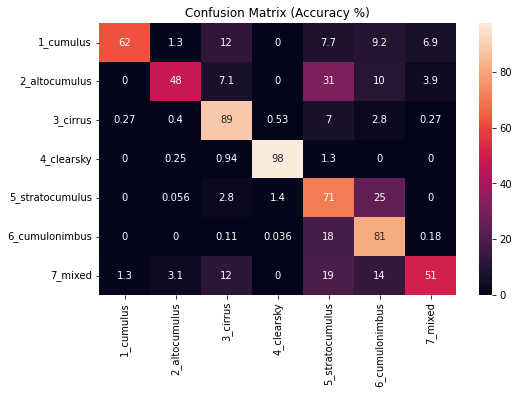

In [26]:
print(f"Global Test accuracy {accuracy_score(test_targets, test_preds)}")

sum_of_rows = matrix.sum(axis=1)
conf_mat = 100*matrix / sum_of_rows[:, np.newaxis]

df_cm = pd.DataFrame(conf_mat, index = class_acc.keys(),
                  columns = class_acc.keys())

plt.figure(figsize = (8,5))
plt.title("Confusion Matrix (Accuracy %)")
sns.heatmap(df_cm, annot=True)